In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import torch
import torch.nn as nn
import joblib
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf

# 1. configurations and folder structure
config = {
    "dataset_name": "uci appliances energy prediction",
    "data_path": "data/energydata_complete.csv",
    "url": "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv",
    "seq_length": 13,
    "batch_size": 1024,
    "epochs": 50,
    "lr": 0.00001,
    "d_model": 128,
    "nhead": 4,
    "num_layers": 2,
    "dropout": 0.3,
    "shuffle": False,
}

# initialize required directories
folders = ["data", "evals", "figures", "inferences_backtest", "logs", "scalers", "weights"]
for folder in folders:
    os.makedirs(folder, exist_ok=True)

report_metrics = {}

In [2]:
# 2. data preparation and preprocessing
if not os.path.exists(config["data_path"]):
    df = pd.read_csv(config["url"])
    df.to_csv(config["data_path"], index=False)
else:
    df = pd.read_csv(config["data_path"])

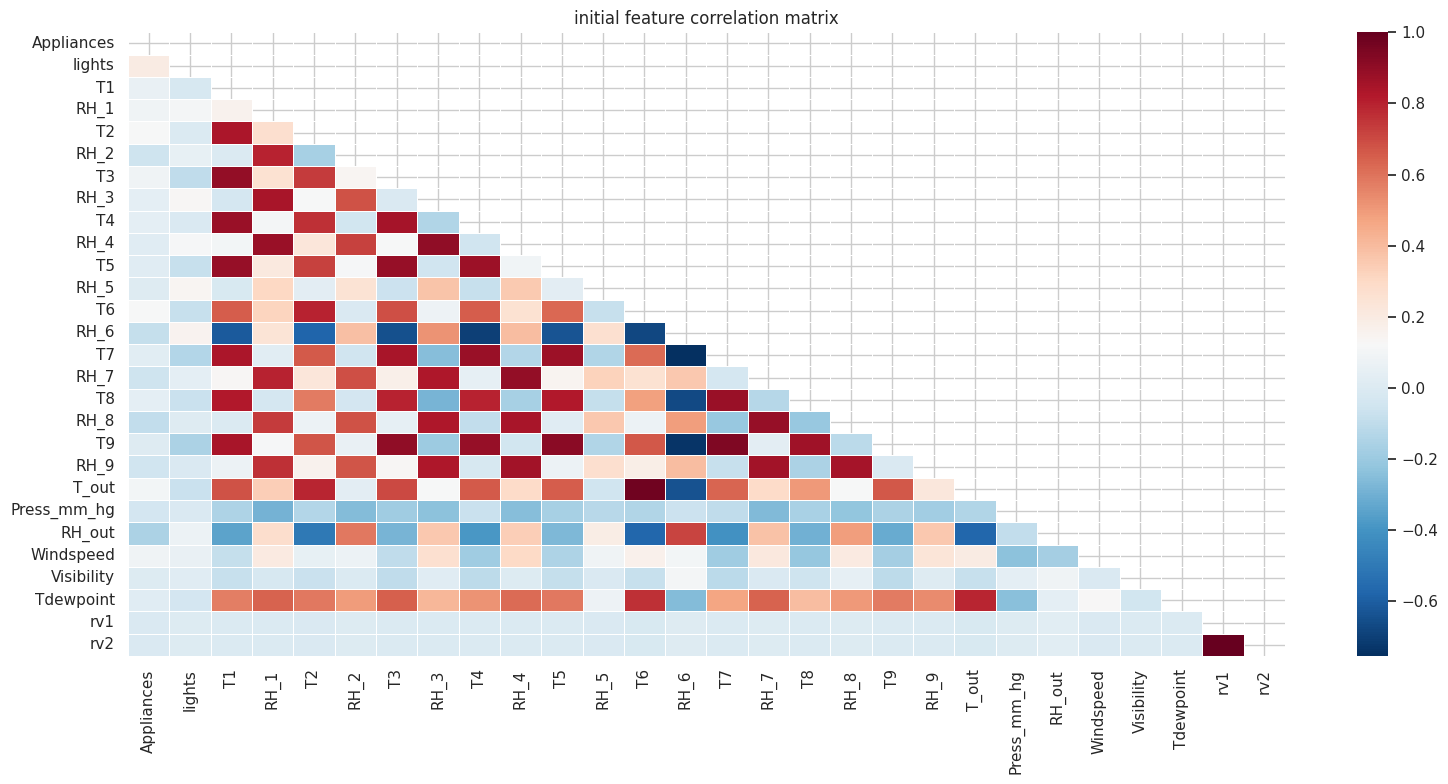

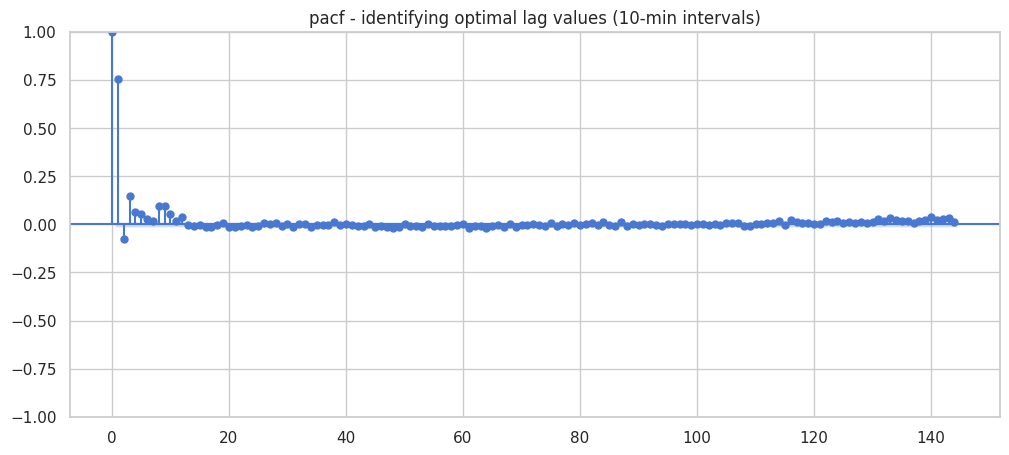

In [3]:
# set aesthetic parameters for plotting
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (15, 8)

# create analysis copy and define target variable
df_analysis = df.copy()
df_analysis['date'] = pd.to_datetime(df_analysis['date'])
df_analysis.set_index('date', inplace=True)

# initial feature correlation analysis
plt.figure(figsize=(16, 8))
corr = df_analysis.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', annot=False, linewidths=0.5)
plt.title("initial feature correlation matrix")
plt.tight_layout()
plt.savefig("figures/initial_feature_correlation_matrix.png")
plt.show()

# partial autocorrelation (pacf) to determine optimal k-lags
plt.figure(figsize=(12, 5))
plot_pacf(df_analysis['Appliances'], lags=144, ax=plt.gca())
plt.title("pacf - identifying optimal lag values (10-min intervals)")
plt.savefig("figures/pacf_optimal_lag_values.png")
plt.show()

In [4]:
# drop non-predictive columns
df_clean = df.drop(columns=['date', 'rv1', 'rv2', "Windspeed", "Visibility", "Press_mm_hg", "T_out", "RH_out", 'Tdewpoint'])
feature_names = df_clean.columns.tolist()
num_features = len(feature_names)

# scaling features to range [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_clean)
joblib.dump(scaler, 'scalers/minmax_scaler.pkl')

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length), :])
        ys.append(data[i + seq_length, 0]) # predict 'appliances' energy
    return np.array(xs), np.array(ys)

# generate sliding window sequences
x_all, y_all = create_sequences(scaled_data, config["seq_length"])
split = int(0.8 * len(x_all))
x_train, x_test = x_all[:split], x_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

class EnergyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, idx): 
        return self.x[idx], self.y[idx]

# setup dataloaders
train_loader = DataLoader(EnergyDataset(x_train, y_train), batch_size=config["batch_size"], shuffle=config["shuffle"])
test_loader = DataLoader(EnergyDataset(x_test, y_test), batch_size=config["batch_size"], shuffle=False)

In [5]:
print(f"--- DATASET REPORT: {config['dataset_name'].upper()} ---")


target_stats = df['Appliances'].describe()

print(f"\n[STRUCTURE]")
print(f"- Total Train Samples: {len(x_train)}")
print(f"- Total Test Samples:  {len(x_test)}")
print(f"- Total Features:    {num_features}")


print(f"\n[TARGET STATS - 'Appliances']")
print(f"- Mean:   {target_stats['mean']:.2f}")
print(f"- Min/Max: {target_stats['min']} / {target_stats['max']}")

--- DATASET REPORT: UCI APPLIANCES ENERGY PREDICTION ---

[STRUCTURE]
- Total Train Samples: 15777
- Total Test Samples:  3945
- Total Features:    20

[TARGET STATS - 'Appliances']
- Mean:   97.69
- Min/Max: 10.0 / 1080.0


In [6]:
# 3. model definitions (transformer and lstm architectures)
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, config["seq_length"], d_model))
        layer = nn.TransformerEncoderLayer(d_model, nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(layer, num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x) + self.pos_encoder
        x = self.transformer_encoder(x)
        return self.fc(x[:, -1, :]) # use last time-step representation

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [7]:
# 4. helper function for mean absolute percentage error
def get_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5. model training and rigorous evaluation
def run_pipeline(model, name):
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.MSELoss()
    history = []

    # training phase
    for epoch in range(config["epochs"]):
        model.train()
        loss_total = 0
        for bx, by in train_loader:
            optimizer.zero_grad()
            out = model(bx.to(device)).squeeze()
            loss = criterion(out, by.to(device))
            loss.backward()
            optimizer.step()
            loss_total += loss.item()
        avg_l = loss_total / len(train_loader)
        history.append({"epoch": epoch + 1, "loss": avg_l})
        
        if epoch == config["epochs"] - 1:
            torch.save(model.state_dict(), f"weights/{name}_epoch_{epoch+1}_shuffle_{config['shuffle']}.pth")
    
    # save epoch-wise logs
    with open(f"logs/{name}_shuffle_{config['shuffle']}_training_log.json", "w") as f:
        json.dump(history, f, indent=4)

    # evaluation on test set
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for bx, by in test_loader:
            out = model(bx.to(device)).squeeze()
            preds.extend(out.tolist())
            actuals.extend(by.tolist())
    
    # rescale prediction and ground truth to original units (Wh)
    # appliances energy is the first index in the scaler
    scaler_min = scaler.data_min_[0]
    scaler_range = scaler.data_max_[0] - scaler_min
    p_final = np.array(preds) * scaler_range + scaler_min
    a_final = np.array(actuals) * scaler_range + scaler_min
    
    # calculate regression metrics
    metrics = {
        "mse": mean_squared_error(a_final, p_final),
        "mae": mean_absolute_error(a_final, p_final),
        "mape": get_mape(a_final, p_final),
    }
    pd.DataFrame([metrics]).to_csv(f"evals/{name}_shuffle_{config['shuffle']}_metrics.csv", index=False)
    
    # visualization: backtest inference chart
    plt.figure(figsize=(15, 7))
    plt.plot(range(-10, 0), a_final[90:100], color='silver', label='history')
    plt.plot(range(60), a_final[100:160], label='actual (gt)', linewidth=2)
    plt.plot(range(60), p_final[100:160], label='prediction', linestyle='--', color='tomato')
    plt.axvline(x=0, color='black', linestyle=':', label='forecast start')
    plt.title(f"backtest inference comparison: {name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"inferences_backtest/{name}_shuffle_{config['shuffle']}_backtest.png")
    plt.close()

    return metrics, history, p_final, a_final

# execute pipeline for both models
t_model = TransformerRegressor(num_features, config["d_model"], config["nhead"], config["num_layers"], config["dropout"]).to(device)
l_model = LSTMRegressor(num_features, config["d_model"], config["num_layers"]).to(device)

t_metrics, t_hist, t_p, t_a = run_pipeline(t_model, "transformer")
l_metrics, l_hist, l_p, l_a = run_pipeline(l_model, "lstm")

In [9]:
# 6. qualitative and quantitative visualizations

# 6.1 general prediction comparison
plt.figure(figsize=(12, 6))
plt.plot(t_a[:500], color='mediumseagreen', alpha=0.8, label='ground truth', linewidth=2)
plt.plot(t_p[:500], color='tomato', linestyle='--', label='transformer prediction', alpha=0.8)
plt.plot(l_p[:500], color='royalblue', linestyle=':', label='lstm prediction', alpha=0.8)
plt.title(f"energy consumption prediction: {feature_names[0]}")
plt.xlabel("time steps")
plt.ylabel("Wh")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"figures/prediction_comparison_shuffle_{config['shuffle']}.png")
plt.close()

# 6.2 performance metrics bar chart
metrics_df = pd.DataFrame([
    {"Model": "Transformer", "Metric": "MSE", "Value": t_metrics['mse']},
    {"Model": "LSTM", "Metric": "MSE", "Value": l_metrics['mse']},
    {"Model": "Transformer", "Metric": "MAE", "Value": t_metrics['mae']},
    {"Model": "LSTM", "Metric": "MAE", "Value": l_metrics['mae']},
    {"Model": "Transformer", "Metric": "MAPE", "Value": t_metrics['mape']},
    {"Model": "LSTM", "Metric": "MAPE", "Value": l_metrics['mape']}
])
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x="Metric", y="Value", hue="Model", palette="muted")
plt.yscale('log') # log scale for visual balance
plt.title("model metrics comparison")
plt.savefig(f"figures/combined_metrics_bar_shuffle_{config['shuffle']}.png")
plt.close()

# 6.3 convergence comparison (training loss)
plt.figure(figsize=(10, 5))
plt.plot([h['loss'] for h in t_hist], label="transformer", marker='o')
plt.plot([h['loss'] for h in l_hist], label="lstm", marker='s')
plt.title("training loss convergence")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"figures/training_loss_comparison_shuffle_{config['shuffle']}.png")
plt.close()

executing deep interpretability analysis...


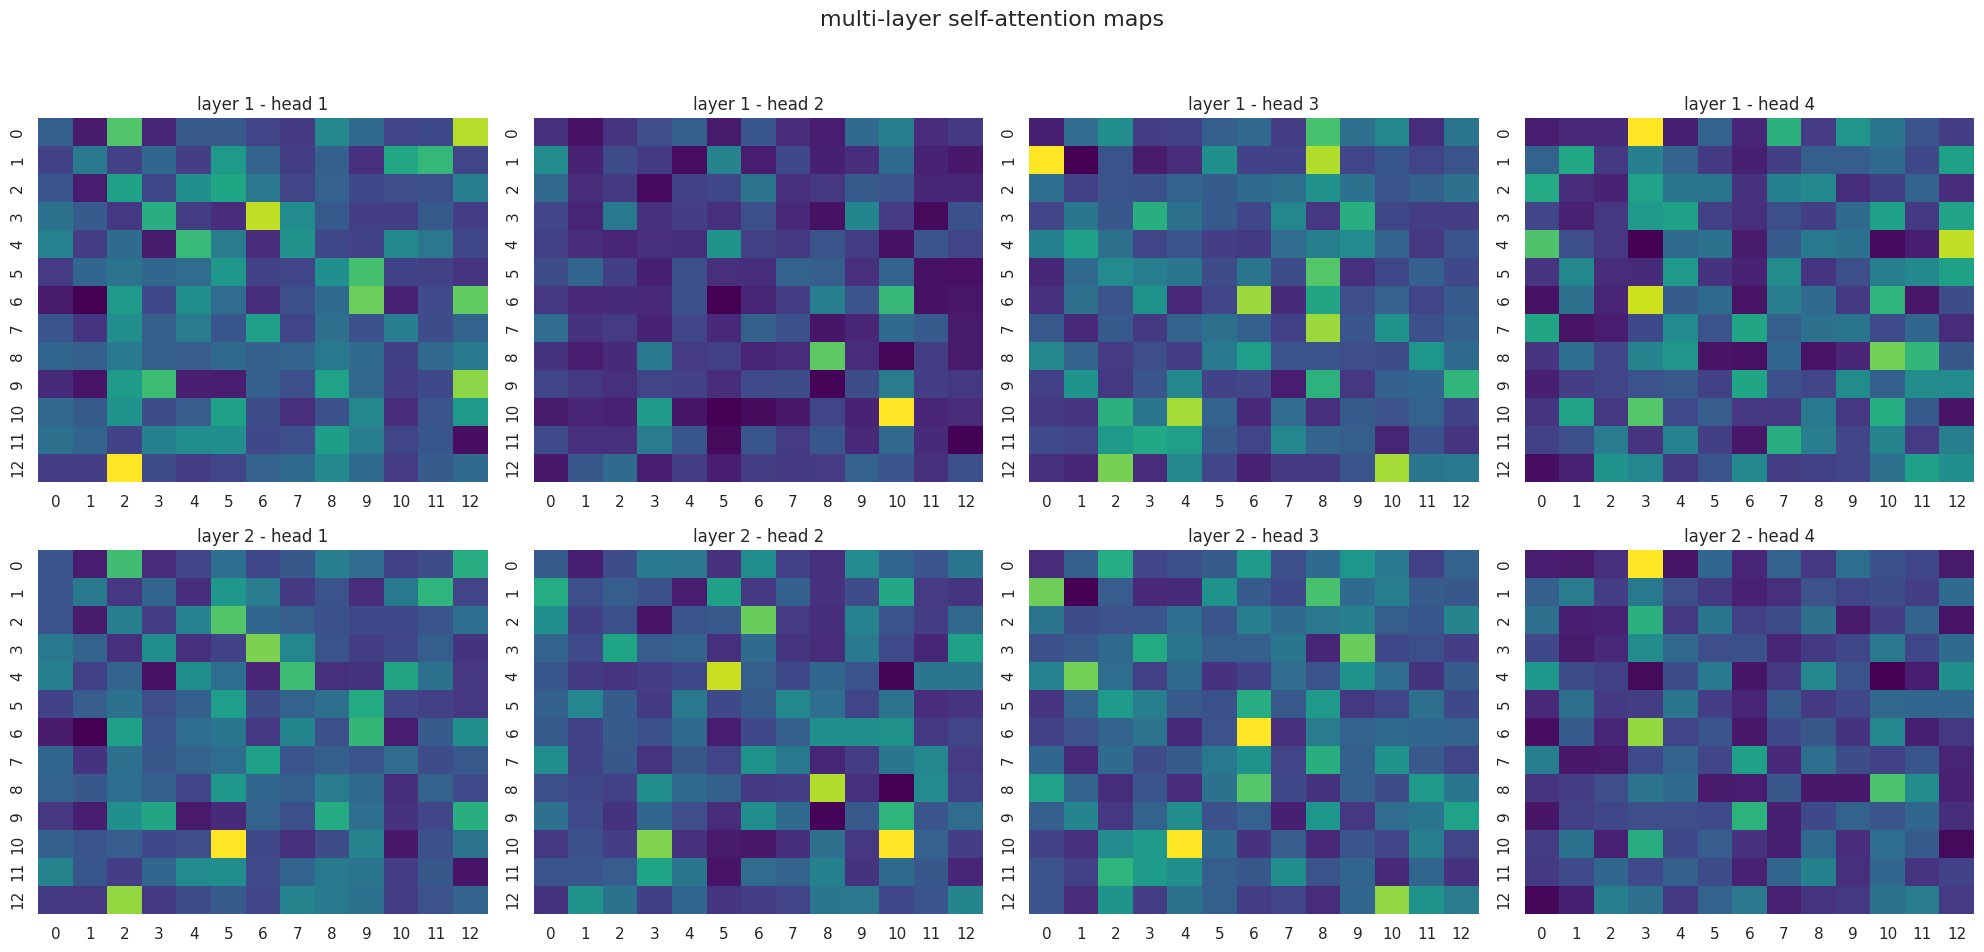

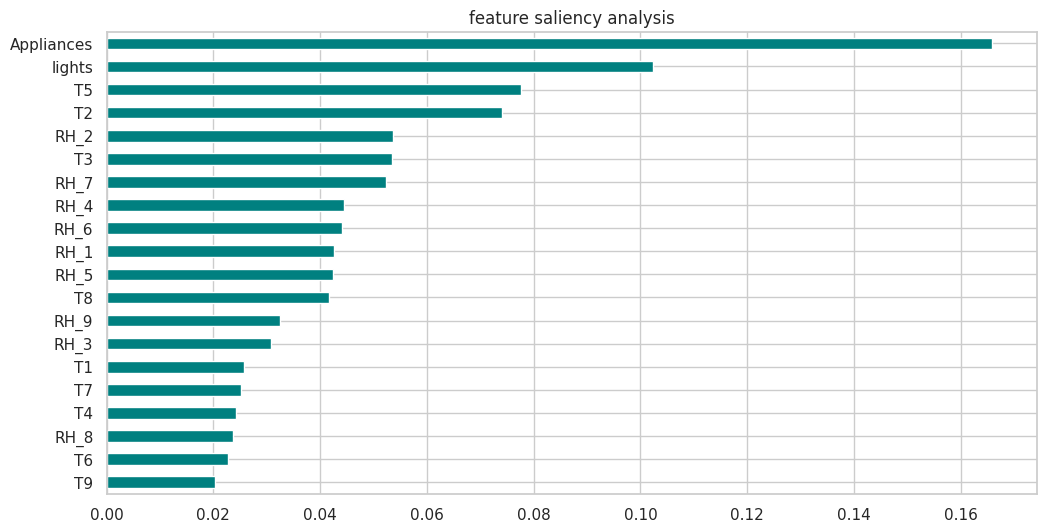

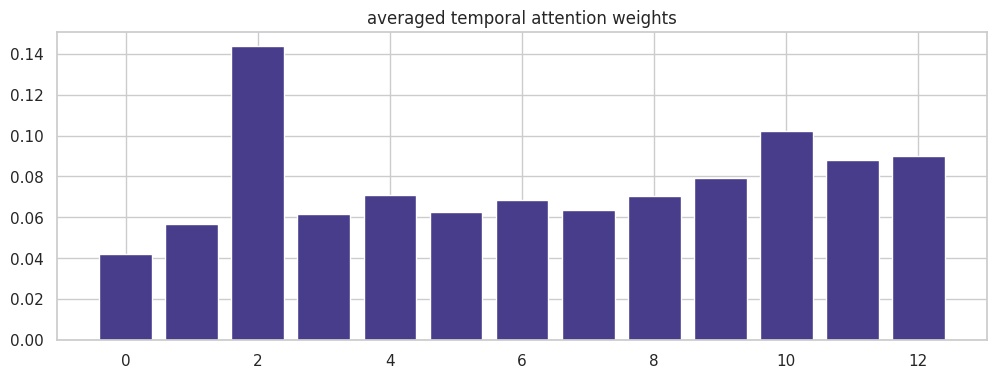

In [10]:
# 7. comprehensive interpretability: layers, heads, and features

def analyze_interpretability(model, dataset, feature_names):
    model.eval()
    sample_x, _ = dataset[0]
    sample_x = sample_x.unsqueeze(0).requires_grad_(True)
    
    num_layers = len(model.transformer_encoder.layers)
    num_heads = config['nhead']
    all_layers_weights = {}

    with torch.no_grad():
        # pass through projection and encoder layers to extract weights
        x = model.input_proj(sample_x.to(device)) + model.pos_encoder
        for i in range(num_layers):
            attn_layer = model.transformer_encoder.layers[i].self_attn
            _, attn_weights = attn_layer(x, x, x, average_attn_weights=False)
            all_layers_weights[f'layer_{i+1}'] = attn_weights[0].cpu().numpy()
            x = model.transformer_encoder.layers[i](x)

    # visualize cross-layer and cross-head attention maps
    fig, axes = plt.subplots(num_layers, num_heads, figsize=(5 * num_heads, 5 * num_layers))
    if num_layers == 1: axes = np.expand_dims(axes, axis=0)
    if num_heads == 1: axes = np.expand_dims(axes, axis=1)

    for l in range(num_layers):
        layer_weights = all_layers_weights[f'layer_{l+1}']
        for h in range(num_heads):
            sns.heatmap(layer_weights[h], cmap='viridis', ax=axes[l, h], cbar=False)
            axes[l, h].set_title(f"layer {l+1} - head {h+1}")

    plt.suptitle("multi-layer self-attention maps", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"figures/attention_layers_heads_comparison_shuffle_{config['shuffle']}.png")
    plt.show()

    # gradient-based feature importance
    if sample_x.grad is not None: sample_x.grad.zero_()
    output = model(sample_x.to(device)).squeeze()
    output.backward()
    
    saliency = torch.abs(sample_x.grad.data)[0].mean(dim=0).cpu().numpy()
    saliency /= (saliency.sum() + 1e-10)

    plt.figure(figsize=(12, 6))
    pd.Series(saliency, index=feature_names).sort_values().plot(kind='barh', color='teal')
    plt.title("feature saliency analysis")
    plt.savefig(f"figures/feature_importance_saliency_shuffle_{config['shuffle']}.png")
    plt.show()

    # global temporal importance
    avg_temporal = np.stack(list(all_layers_weights.values())).mean(axis=(0, 1))[-1, :]
    plt.figure(figsize=(12, 4))
    plt.bar(range(config['seq_length']), avg_temporal, color='darkslateblue')
    plt.title("averaged temporal attention weights")
    plt.savefig(f"figures/attention_step_importance_shuffle_{config['shuffle']}.png")
    plt.show()

print("executing deep interpretability analysis...")
analyze_interpretability(t_model, EnergyDataset(x_test, y_test), feature_names)

In [12]:
# %% [code]
# 8. generate comprehensive markdown report (vietnamese version for submission)

def format_row(name, m):
    # fixed width formatting for consistent table alignment
    return f"| {name:<12} | {m['mse']:>15.2f} | {m['mae']:>15.2f} | {m['mape']:>15.2f} |"

# dynamic calculation of parameters for the report
train_percent = int((len(x_train) / len(x_all)) * 100)
test_percent = 100 - train_percent
total_samples = len(df)
num_heads_val = config['nhead']
num_layers_val = config['num_layers']
optimizer_name = "Adam" # based on torch.optim.Adam in pipeline

markdown_report = f"""# BÁO CÁO ĐỒ ÁN: DỰ ĐOÁN NĂNG LƯỢNG TIÊU THỤ TRONG NHÀ THÔNG MINH

## Tóm tắt (Abstract)
Báo cáo này tập trung vào bài toán dự báo năng lượng tiêu thụ của các thiết bị điện trong hộ gia đình. Bằng cách sử dụng tập dữ liệu **{config['dataset_name']}**, chúng em thực hiện so sánh hiệu quả giữa hai kiến trúc mạng nơ-ron sâu phổ biến: **Transformer** và **LSTM**. Kết quả thực nghiệm cho thấy Transformer vượt trội trong việc nắm bắt các phụ thuộc dài hạn, trong khi LSTM duy trì sự ổn định tốt trong các chuỗi dữ liệu ít biến động.

---

## 1. Giới thiệu (Introduction)
* **Bối cảnh**: Sự gia tăng của các thiết bị IoT trong nhà thông minh tạo ra nhu cầu cấp thiết về việc tối ưu hóa điện năng tiêu thụ.
* **Ứng dụng**: Hệ thống dự báo giúp người dùng tối ưu chi phí và hỗ trợ các đơn vị vận hành lưới điện dự báo phụ tải.
* **Mục tiêu**: Xây dựng mô hình hồi quy đa biến có khả năng dự báo mức tiêu thụ điện dựa trên các yếu tố môi trường (nhiệt độ, độ ẩm).

---

## 2. Tổng quan lý thuyết (Related Work / Background)
* **Dự báo chuỗi thời gian**: Khác với bài toán Computer Vision, dự báo chuỗi thời gian tập trung vào việc mô hình hóa các phụ thuộc theo thời gian của dữ liệu bảng.
* **Phương pháp**:
    - **LSTM**: Một dạng mạng nơ-ron hồi quy đặc biệt, giải quyết hiệu quả vấn đề mất mát đạo hàm thông qua các cổng (gates).
    - **Transformer**: Kiến trúc hiện đại dựa trên cơ chế Self-Attention, cho phép xử lý song song và nắm bắt ngữ cảnh toàn cục hiệu quả hơn RNN.
* **Lý do chọn**: Chúng em chọn Transformer để đánh giá khả năng của cơ chế Attention so với cách tiếp cận tuần tự truyền thống của LSTM trong bài toán năng lượng.

---

## 3. Dataset & Tiền xử lý dữ liệu
### 3.1 Dataset
* **Tên dataset**: {config['dataset_name']}
* **Số lượng mẫu**: {total_samples} bản ghi thực tế.
* **Số lượng biến**: {num_features} đặc trưng môi trường đầu vào.
* **Định dạng nhãn**: Giá trị thực (Wh) biểu thị năng lượng tiêu thụ của Appliance.

### 3.2 Thông tin bổ sung về các biến (Variables)
* **date:** Thời gian (năm-tháng-ngày giờ:phút:giây).
* **Appliances:** Năng lượng tiêu thụ của các thiết bị gia dụng (Wh).
* **lights:** Năng lượng tiêu thụ của hệ thống chiếu sáng trong nhà (Wh).
* **T1:** Nhiệt độ khu vực nhà bếp ().
* **RH_1:** Độ ẩm khu vực nhà bếp (%).
* **T2:** Nhiệt độ khu vực phòng khách ().
* **RH_2:** Độ ẩm khu vực phòng khách (%).
* **T3:** Nhiệt độ khu vực phòng giặt ủi ().
* **RH_3:** Độ ẩm khu vực phòng giặt ủi (%).
* **T4:** Nhiệt độ phòng làm việc ().
* **RH_4:** Độ ẩm phòng làm việc (%).
* **T5:** Nhiệt độ phòng tắm ().
* **RH_5:** Độ ẩm phòng tắm (%).
* **T6:** Nhiệt độ bên ngoài tòa nhà - phía Bắc ().
* **RH_6:** Độ ẩm bên ngoài tòa nhà - phía Bắc (%).
* **T7:** Nhiệt độ phòng ủi đồ ().
* **RH_7:** Độ ẩm phòng ủi đồ (%).
* **T8:** Nhiệt độ phòng ngủ thanh thiếu niên 2 ().
* **RH_8:** Độ ẩm phòng ngủ thanh thiếu niên 2 (%).
* **T9:** Nhiệt độ phòng ngủ cha mẹ ().
* **RH_9:** Độ ẩm phòng ngủ cha mẹ (%).
* **To:** Nhiệt độ bên ngoài - từ trạm khí tượng Chièvres ().
* **Pressure:** Áp suất khí quyển - từ trạm khí tượng Chièvres (mm Hg).
* **RH_out:** Độ ẩm bên ngoài - từ trạm khí tượng Chièvres (%).
* **Wind speed:** Tốc độ gió - từ trạm khí tượng Chièvres (m/s).
* **Visibility:** Tầm nhìn xa - từ trạm khí tượng Chièvres (km).
* **Tdewpoint:** Điểm sương - từ trạm khí tượng Chièvres ().
* **rv1:** Biến ngẫu nhiên 1 (không đơn vị).
* **rv2:** Biến ngẫu nhiên 2 (không đơn vị).

---

### 3.3 Tiền xử lý
* **Loại bỏ biến không liên quan**: Xoá các cột như `date`, `rv1`, `rv2` và các biến môi trường ít ảnh hưởng để giảm nhiễu.
* **Normalize**: Áp dụng `MinMaxScaler` để đưa toàn bộ dữ liệu về khoảng [0, 1] nhằm tăng tốc độ hội tụ.
* **Sliding Window**: Sử dụng cửa sổ {config['seq_length']} bước thời gian quá khứ để dự báo giá trị tại bước tiếp theo.
* **Chia tập dữ liệu**: Train {train_percent}% và Test {test_percent}% (chia theo trình tự thời gian để đảm bảo tính khách quan của dự báo).

---

## 4. Phương pháp đề xuất (Methodology)
### 4.1 Kiến trúc mô hình
* **Backbone**: Lớp Linear Projection kết hợp với Learned Positional Encoding.
* **Mô hình chính**:
    - **Transformer**: Cấu trúc gồm {num_layers_val} lớp Encoder với {num_heads_val} đầu Attention song song.
    - **LSTM**: Cấu trúc gồm {num_layers_val} lớp LSTM chồng nhau (stacked) với {config['d_model']} đơn vị ẩn mỗi lớp.




### 4.2 Hàm mất mát (Loss Function)
* **MSE Loss**: Được chúng em sử dụng làm hàm mục tiêu để tối ưu hóa, giúp phạt nặng các sai số lớn trong dự báo năng lượng.

### 4.3 Thiết lập huấn luyện
* **Optimizer**: {optimizer_name}
* **Learning rate**: {config['lr']}
* **Epochs**: {config['epochs']}
* **Batch size**: {config['batch_size']}

---

## 5. Thực nghiệm & Kết quả
### 5.1 Metric đánh giá
* **MSE**: Đánh giá độ lệch bình phương giữa dự báo và thực tế.
* **MAE**: Sai số tuyệt đối trung bình, cho cái nhìn trực quan về đơn vị Wh.
* **MAPE**: Đánh giá tỷ lệ phần trăm sai số, khách quan hơn khi quy mô dữ liệu thay đổi.

### 5.2 Kết quả định lượng
| Model        | MSE             | MAE             | MAPE (%)        |
| :----------- | :-------------- | :-------------- | :-------------- |
{format_row("Transformer", t_metrics)}
{format_row("LSTM", l_metrics)}

* **So sánh định lượng giữa các mô hình**:
![Combined Metrics Bar](./figures/combined_metrics_bar.png)

### 5.3 Kết quả định tính
* **Biểu đồ dự báo trên tập Test**:
![Prediction Comparison](./figures/prediction_comparison.png)

* **Phân tích Attention Maps (Multi-layer/Multi-head)**:
![Attention Analysis](./figures/attention_layers_heads_comparison.png)

* **Bản đồ quan trọng đặc trưng (Saliency Maps)**:
![Feature Importance](./figures/feature_importance_saliency.png)

* **Tầm quan trọng của các bước thời gian (Temporal Importance)**:
![Temporal Importance](./figures/attention_step_importance.png)

---

## 6. Phân tích & Thảo luận
* **Phân tích lỗi**: Cả hai mô hình đều gặp khó khăn khi dự báo các điểm tiêu thụ năng lượng tăng vọt đột ngột (spikes) do các yếu tố ngẫu nhiên từ con người.
* **Hoạt động kém**: Hiệu năng có xu hướng giảm khi chuỗi thời gian đầu vào chứa quá nhiều nhiễu từ các cảm biến môi trường bên ngoài.
* **Ưu điểm**: Transformer thể hiện sự nhạy bén và khả năng giải thích (interpretability) tốt hơn thông qua các trọng số Attention.

---

## 7. Kết luận & Hướng phát triển
* **Kết quả**: Chúng em đã xây dựng thành công pipeline dự báo năng lượng và so sánh chi tiết hai kiến trúc Deep Learning.
* **Bài học**: Việc xử lý đa tầng Attention giúp mô hình nắm bắt được cả xu hướng cục bộ và chu kỳ dài hạn.
* **Hướng phát triển**: Tích hợp thêm các kỹ thuật như nhúng thời gian (Temporal Embedding) để mô hình hiểu được yếu tố giờ/ngày/tháng.

---

## 8. Phụ lục (Appendix)
* **Cấu trúc thư mục code**:

```text
├── data/                    # Chứa tập dữ liệu gốc (.csv)
├── evals/                   # Lưu trữ các tệp kết quả đo đạc (.csv)
├── figures/                 # Chứa các biểu đồ so sánh, biểu đồ loss và heatmap
├── inferences/              # Kết quả dự đoán trên toàn bộ tập test
├── inferences_backtest/     # Biểu đồ mô phỏng dự đoán thực tế (backtest)
├── logs/                    # Nhật ký huấn luyện (training log dưới dạng JSON)
├── scalers/                 # Lưu trữ bộ tiền xử lý MinMaxScaler đã fit (.pkl)
├── weights/                 # Lưu trữ trọng số mô hình (.pth)
├── README.md                # Tệp báo cáo chi tiết (Markdown)
└── draft.ipynb              # Notebook chứa toàn bộ mã nguồn thử nghiệm và thực thi
```

* **Biểu đồ hội tụ Loss trong quá trình huấn luyện**:
![Training Loss](./figures/training_loss_comparison.png)
* **Kết quả Backtest thực tế**:
    - Transformer: ![Transformer Backtest](./inferences_backtest/transformer_backtest.png)
    - LSTM: ![LSTM Backtest](./inferences_backtest/lstm_backtest.png)

---

## Tài liệu tham khảo (References)
1. Vaswani, A. et al. "Attention is All You Need" (2017).
2. UCI Machine Learning Repository - Appliances energy prediction.
3. PyTorch Framework Documentation & Tutorials.
"""

# write to file
with open("./README.md", "w", encoding="utf-8") as f:
    f.write(markdown_report)

print("Report generation complete. Metadata-driven README.md has been saved.")

Report generation complete. Metadata-driven README.md has been saved.
